Requires notebook 1.

In [1]:
suppressPackageStartupMessages({
  library(alphahull)
  library(cowplot)
  library(dataorganizer)
  library(EBImage)
  library(ggplot2)
  library(ggrastr)
  library(magrittr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load data
data <- prepare_gut_tx_and_meta()
cell_annot <- data[[1]]
df <- data[[2]]
rna_markers <- load_markers_gut()
colnames(rna_markers) <- c('Gene','cluster')

df$fov <- 1
df$z_index <- dense_rank(df$z) # need z_index for indexing the stain image. Code also assumes it's 0 indexed.
df_for_memb <- df[,c('x','y','z_index','z','cell','celltype','fov','mol_id','gene')]
df_for_memb$z <- df_for_memb$z_index

In [3]:
# load stain images
file_nm <- DatasetPath('mouse_gut', 'raw_data', 'dapi_stack.tif') # for bayes
stains_dapi <- file_nm %>% readImage() %>% imageData()
file_nm <- DatasetPath('mouse_gut', 'raw_data', 'membrane_stack.tif') # for bayes
stains_membrane <- file_nm %>% readImage() %>% imageData()

stains_colored_per_z = c(2, 3, 4, 6) %>% setNames(., .) %>% sccore::plapply(\(z) {
  list(stains_membrane[,,z], stains_dapi[,,z]) %>%
    combinedStainImage(palettes=c("Greens","Purples"), clip.min=c(0.5, 0.5), clip.max=c(0.996, 0.975))
}, n.cores=4)

stains_colored_per_z %<>% lapply(\(st) st[rev(seq_len(nrow(st))),])

colors <- c(enterocyte="#F8766D", goblet="#00BFC4", `non-marker`="black")
shape_scales <- c(enterocyte=24, goblet=21, `non-marker`=22)

cp_theme <- theme_legend(position=c(1, 1), background.alpha=0.6) + theme(
  panel.grid=element_blank(),
  legend.key=element_blank(),
  legend.text=element_text(size=14),
  legend.title=element_text(size=14, face="bold"),
  plot.title=element_text(hjust=0.02, vjust=-7, face = "bold", size=14),
  plot.margin=margin(0.1, 0.1, 0.1, 0.1, unit="in"),
  axis.title=element_blank()
)

In [6]:
cells_plot <- c("cell_4930", "cell_2688", "cell_2333", "cell_4930", "cell_2688", "cell_2333")
z_levs <- c(2, 3, 3, 4, 6, 4)


gg_cells <- lapply(1:length(cells_plot),function(p_ndx) {
  full.id <- cells_plot[p_ndx]
  zval <- z_levs[p_ndx]
  df_cell = df_for_memb[df_for_memb$cell==full.id,]
  df_cell %>% mutate(
    source=ifelse(
      gene %in% rna_markers$Gene[rna_markers$cluster=='Enterocyte'], 'enterocyte',
      ifelse(
        gene %in% rna_markers$Gene[rna_markers$cluster=='Goblet'], 'goblet',
        'non-marker'
      )
    )
  ) %>%
    mutate(source=factor(source, levels=c('goblet', 'enterocyte', 'non-marker'))) %>%
    plotCellAdmixture(
      stains=stains_colored_per_z,
      cell.id=full.id, z.id=zval, filter.z=TRUE, expand=0.15,
      color.scale=colors, shape.scale=shape_scales,
      size=3,
      bg.name='non-marker',inv.y.global=TRUE,inv.y.local=FALSE
    ) + cp_theme + ggtitle(paste0("Cell ", full.id))
})

tv <- seq(0, 1, 0.01)
leg_gg_base <- ggplot(data.frame(x=tv)) + geom_point(aes(x=x, y=x, color=x)) +
  cp_theme +
  guides(color=guide_colorbar(direction = "horizontal", title.position = "top", barwidth = 11, barheight = 0.75))

lgg1 <- leg_gg_base + scale_color_distiller(palette="Greens", direction=1, name="Membrane")
lgg2 <- leg_gg_base + scale_color_distiller(palette="Purples", direction=1, name="DAPI")


tlg <- guide_legend(direction="horizontal", title.position="top", title="Marker type")
lgg0 <- gg_cells[[1]] + guides(fill=tlg, shape=tlg, size=tlg)

gg_cells2 <- gg_cells %>% lapply(rasterise, layers="Tile") %>%
  lapply(`+`, theme(legend.position="none")) %>% {plot_grid(plotlist=., ncol=3)}
legends <- list(lgg0, lgg1, lgg2) %>% lapply(
  get_plot_component, 'guide-box-inside', return_all=TRUE
)

legends <- plot_grid(plotlist=legends, nrow=1)

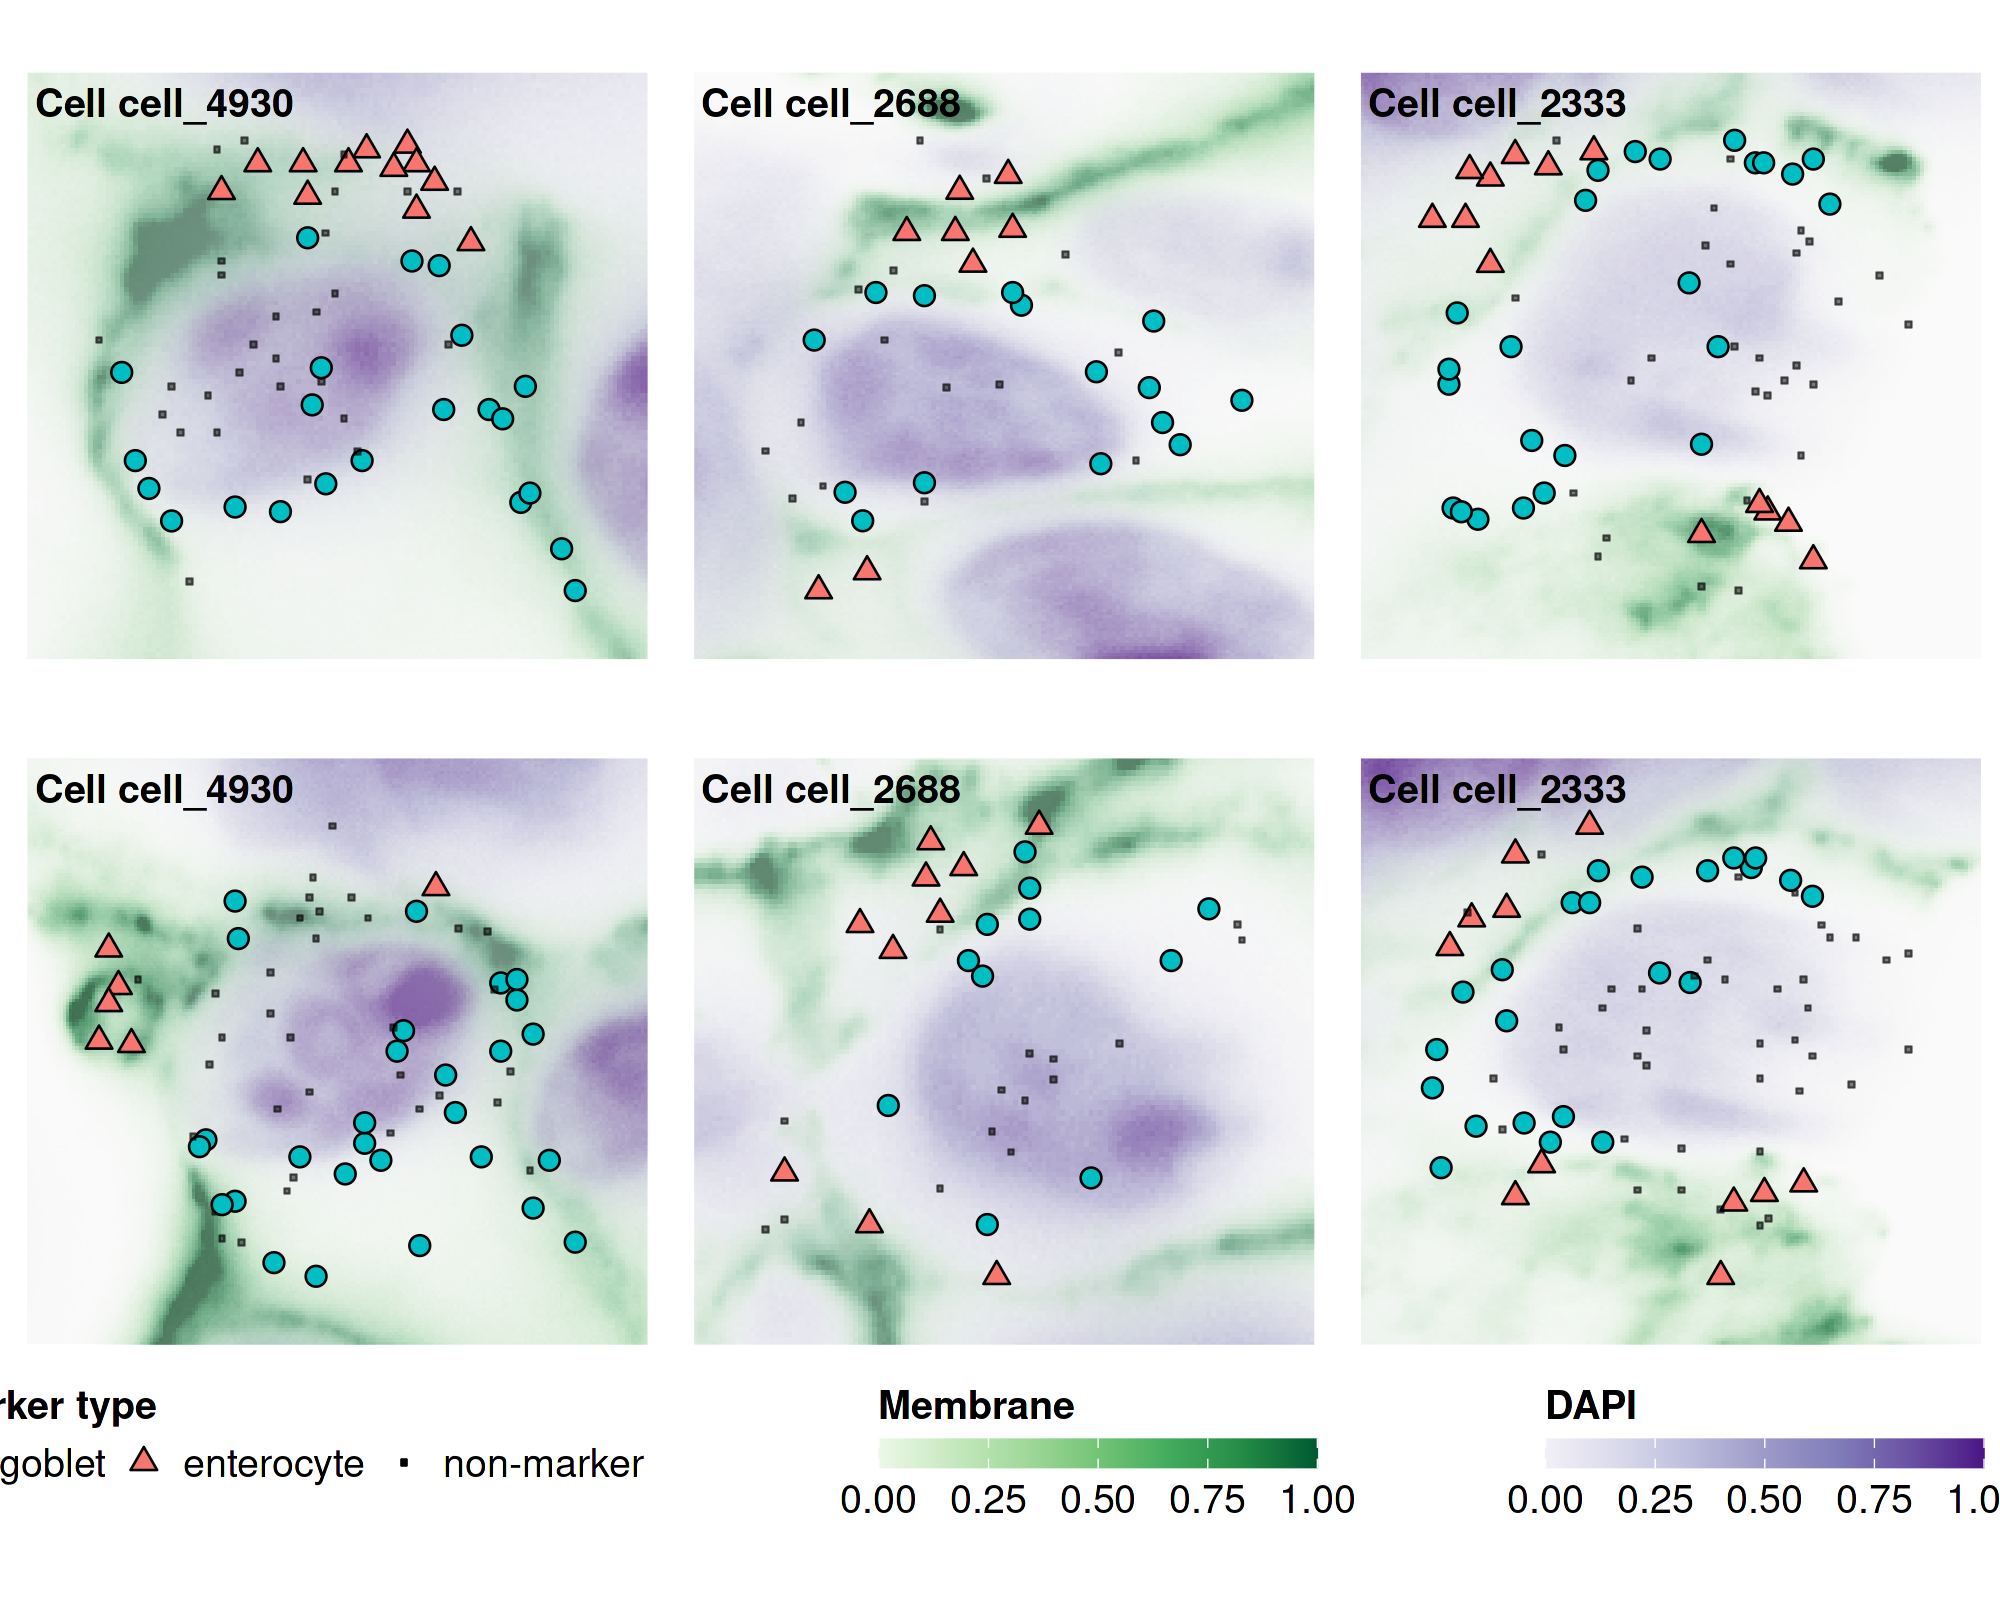

In [7]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)

fig <- plot_grid(plotlist=list(gg_cells2,legends), nrow=2, rel_heights=c(4.5, 0.75))
fig

In [8]:
pdf(OutputPath("gut_example_cells.pdf"), useDingbats=FALSE, width=10, height=8)
fig
dev.off()

png 
  2